# Cardiovascular disease Prediction

Cardiovascular diseases are the No.1 reason for all deaths in the world [[WHO](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds) )] and many are preventable.

There are many subgroups of different kind of diseases centred around the heart and the blood vessels:

- coronary heart disease – disease of the blood vessels supplying the heart muscle
- cerebrovascular disease – disease of the blood vessels supplying the brain
- peripheral arterial disease – disease of blood vessels supplying the arms and legs
- rheumatic heart disease – damage to the heart muscle and heart valves from rheumatic fever, caused by streptococcal bacteria
- congenital heart disease – malformations of heart structure existing at birth
- deep vein thrombosis and pulmonary embolism – blood clots in the leg veins, which can dislodge and move to the heart and lungs.

The typical risk factors of Cardiovascular diseases are:

- Behavioral:
    - diet,
    - physical inactivity,
    - tobacco use and
    - harmful use of alcohol.

- Medical Values:
    - raised blood pressure,
    - raised blood glucose,
    - raised blood lipids and
    - overweight & obesity


The risk factors mentioned above are quite numerous, and a doctor is only so good at asking questions and data control.
Our motivation for this project is to help doctors and patients by providing a tool that is able to make a prediction if one it subjected to a cardiovascular disease.
This prediction is based on objective, measured and subjective information where most details can be easily obtained by the patients themselves or simple measurements.
The Machine Learning model might therefore be a useful tool to bring attention to early stages and to minimize examination mistakes by providing a second opinion.

## Dataset

To make this prediction possible we found a dataset with said risk factors as features, and the label based on the Cardiovascular disease status.

This dataset is taken from Kaggle.com and can be found [here](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset).

The dataset has data recordings of 70 000 patients containing 11 different Features and one label. There are three types of input features:

* Objective:    factual information
* Examination:  results of medical examination
* Subjective:   information given by the patient

| [index] id| [0] age| [1] gender| [2] height| [3] weight|
| ---| ---| ---| ---| ---|
| int| int| 1 or 2 | int| float|
| -| days| categorical code (2=men)| cm| kg |
| -| Objective| Objective| Objective| Objective |

| [4] ap_hi| [5] ap_lo| [6] cholesterol| [7] gluc|
| ---| ---| ---| ---|
| int| int| 1, 2, 3 | 1, 2, 3 |
| -| -| normal, above normal, well above normal| normal, above normal, well above normal|
| Examination| Examination| Examination| Examination|

>Note: ap_hi = Systolic blood pressure, ap_lo = Diastolic blood pressure, gluc = Glucose

| [8] smoke| [9] alco| [10] active| [11] cardio|
| ---| ---| ---| ---|
| binary| binary| binary| binary |
| -| -| -| categorical code|
| Subjective| Subjective| Subjective| Target|

>Note: alco = Alcohol intake



## EDA - Data Correlation

A good start for choosing the correct prediction algorithm is an exploratory data analysis (EDA).
This analysis looks at the data and shows potential correlations or problems.

More information and details can be found in this [report](../docs/CardioVascular-Diseas-Prediction.html).
This report was compiled using the [pandas-profiling tool](https://github.com/pandas-profiling/pandas-profiling).

 - The report shows that some data is corrupt and needs to be fixed (e.g. implausible blood pressure values).
 - The data is not linear separable, so we definitely need a good feature function or kernel.
 - The result of the prediction should be a category and not a continuous quantity, so we want a classifier.


Based on the these results a good choice for a prediction algorithm in our project is the **Kernel Logistic Regression**.


Based on the WHO's [cardiovascular risk charts](https://www.who.int/news/item/02-09-2019-who-updates-cardiovascular-risk-charts)
being male/elderly/a smoker or having diabetes/high cholesterol levels are the most prominent risk factors for having a cardiovascular disease.


To get a better understanding of our dataset and the relation between the variables, we compute the correlation matrix.


Text(0.5, 1.0, 'Correlation Matrix')

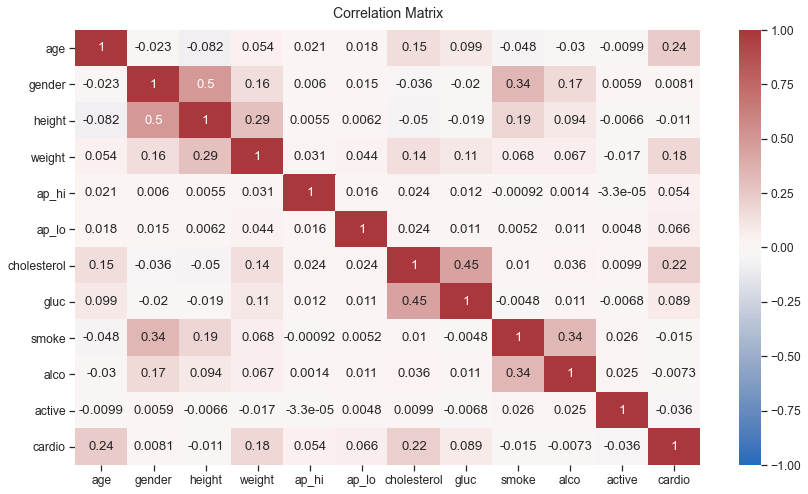

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
plot_df = pd.read_csv('../resources/cardio_train.csv', sep=';', index_col='id')#.sample(1000, random_state=42)

plt.figure(figsize=(14, 8))
sns.heatmap(plot_df.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.title('Correlation Matrix', fontdict={'fontsize':14}, pad=12)

### Data Abnormalities

By looking into the last column, we can see the variables of our dataset which correlate most to a cardiovascular disease.
In our case the biggest influences are, with decreasing significance, the features `age`, `cholesterol`, `weight`, `gulcose` and blood pressure (`ap_lo`/`ap_hi`).

This aligns mostly with the medical values mentioned by the WHO.

Contrary to the aforementioned WHO's cardiovascular risk charts, the `gender` of a person is of minor importance.

Surprisingly, `smoking` and high `alcohol` intake seem to lessen the risk of cardiovascular disease.
Perhaps these features may have gotten mixed up during data collection, but as this is a kaggle-dataset with no reference to the original source,
we cannot know for sure.

We plot the features `age` and `weight` in order to visualize the trend in the data.

Text(0, 0.5, 'weight in kg')

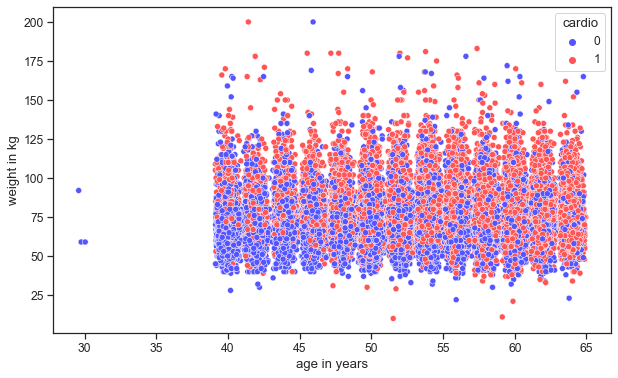

In [2]:
# take age & round days to years
age = plot_df['age']
age_divider = 1.0/365.0
age = age * age_divider

# create age data in correlation with cardio
age_data = pd.concat([age, plot_df['weight'], plot_df['cardio']], axis=1, join='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='weight', data=age_data, hue='cardio', palette="seismic")
plt.xlabel('age in years')
plt.ylabel('weight in kg')

# TODO Leo/Jan: label into ['cardio true', 'cardio false']


As expected, there tend to be more healthy cases in the lower left part of the scatter plot (low age/ low weight) than in the upper right (high age/ high weight).
Nevertheless, it should also be noted that there are many outliers, as well as some values that don't make any sense (e.g. an adult person with only 10 kg).

It may be advantageous to exclude these outliers before training our model.

The plot also shows that our dataset seems to have a weird peculiarity in the feature `age`.
Instead of a smooth distribution over the years, some clusters can be observed.
While we do convert the age (given in days) into years, we keep our value as a float and do not round the value.
We assume that some kind of limitation in the creation process is the reason for these jumps in the data.
Our dataset might just be a subset of an even larger dataset as it mostly includes patients in the age group 39-66 years.
This peculiarity does cause some concern for trust into the data source, but for our project it is important that no unexpected trends emerge, and our dataset is still a representation of the real world.

Luckily this is the case: when compared with the WHO's risk tables the trend "higher age, more cases of cardio diseases" is still valid.

### Duplicate Entries

Our dataset is clearly not very clean.
If it also contains duplicate rows, they may end up in both the training set and the test set, which might be a problem
for estimating the generalization error if they are the result of the poor data collection process.
However, with a dataset consisting of 70000 entries some duplicates are to be expected.

There appears to be only 41 entries with the exact same feature values - with only 24 of these also matching the same label.
We conclude that there is no need for deleting these duplicate rows, because they probably represent real world data.

In [3]:
features = plot_df.columns[:-1]

duplicates_features = plot_df[plot_df.duplicated(features)]
duplicates = plot_df[plot_df.duplicated()]

print(f"Our dataset contains {len(duplicates_features)} duplicates (varying labels)")
print(f"Our dataset contains {len(duplicates)} duplicates (matching labels)")

Our dataset contains 41 duplicates (varying labels)
Our dataset contains 24 duplicates (matching labels)


In [4]:
# Clean up Jupyter Notebook for better performance
%reset -f

# Kernel Logistic Regression

#### Formulary
Features: $x$

Labels: $y$

Hypothesis Function: $h(x)$

Loss Function: $l(h(x), y)$

Regularization Term: $\Omega(w)$

Objective Function: $ J(w) = \frac{1}{m} \sum_{i=1}^{m} l(h(x_i), y_i) + \Omega(w)$


### Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

%load_ext autotime

### Load Data

In [6]:
df = pd.read_csv('../resources/cardio_train.csv', sep=';', index_col='id')

### Removing corrupted entries

As we saw in the exploratory data analysis, our dataset includes corrupted values (e.g. blood pressures above 20000) that need to be expelled before we can make a solid prediction.

Therefore, we define reasonable value ranges for the systolic (`ap_hi`)/ diastolic (`ap_lo`) blood pressures,
`weight` and `height` features in order to account for any errors during the data collection process.

In [7]:
org_count = len(df)

df = df[(50 <= df['ap_lo']) & (df['ap_lo'] <= 150)]
df = df[(100 <= df['ap_hi']) & (df['ap_hi'] <= 200)]

df = df[(25 <= df['weight']) & (df['weight'] <= 400)]
df = df[(100 <= df['height']) & (df['height'] <= 210)]

new_count = org_count - len(df)
print(f"{new_count} entries have been excluded due to implausible feature values.")

del new_count, org_count

2489 entries have been excluded due to implausible feature values.


### Feature Scaling

The information provided by the dataset depends on the category. Some are binary values like `gender`, others are categorical like `cholesterol` or numerical like `weight` and `height`.
We need to normalize these data points to a similar scale. This process is called feature scaling.

Feature Scaling is necessary because if the range of raw data varies widely, it can be the case that the objective function of some machine learning algorithms will not work properly.
This is also the case for the kernel logistic regression.
The main reason for this is that the squared exponential kernel algorithm calculates the squared/euclidean distance between the feature points.
If one Feature has a broad value range the distance is determined and influenced mostly by this particular feature.

Since the Cardiovascular Disease Dataset has a broad value range for example for the Feature `age` (given in days),
we standardize our data such that all features have a mean of zero and a standard deviation of 1.
We use the standardization formula:

$\tilde{x_i} = \frac{x_i - \mu}{\sigma}$

In [8]:
import statistics

def standardize(feature):
    return (feature-statistics.mean(feature)) / statistics.stdev(feature)

df_standardized = pd.DataFrame({})

# numerical values
df_standardized['age'] = standardize(df['age'])
df_standardized['height'] = standardize(df['height'])
df_standardized['weight'] = standardize(df['weight'])
df_standardized['ap_hi'] = standardize(df['ap_hi'])
df_standardized['ap_lo'] = standardize(df['ap_lo'])

# binary/categorical values
df_standardized['gender'] = df['gender'].apply(lambda t: -1 if t==1 else 1).values
df_standardized['smoke'] = df['smoke'].apply(lambda t: -1 if t==0 else 1).values
df_standardized['alco'] = df['alco'].apply(lambda t: -1 if t==0 else 1).values
df_standardized['active'] = df['active'].apply(lambda t: -1 if t==1 else 1).values
df_standardized['cholesterol'] = df['cholesterol'].apply(lambda t: -1 if t==1 else (0 if t==2 else 1)).values
df_standardized['gluc'] = df['gluc'].apply(lambda t: -1 if t==1 else (0 if t==2 else 1)).values

df_standardized['cardio'] = df['cardio'].apply(lambda t: 1 if t==1 else -1).values


del df

### Kernel / Feature function
For the best result we want to include many of our important risk factors into our feature function.

Based on our EDA we can say that our data is - as it is - not linear separable.
We could introduce extra dimension, find random combination or ask a domain expert which feature combination might be linear separable.
This neither fun nor easy, so kernelizing our feature function makes more sense.


For the kernel function a popular choice is the squared exponential kernel. This kernel is a universal approximator which is also a good solution for our Project,
 since it allows us to approximate the unknown feature function without much effort.

$h(x) = w^T * \Phi(x_i)= K(x,z) = exp(\frac{− ∥x − z∥^2 }{2σ^2})$ with $σ > 0$

## Implementing the objective function & helper functions

#### Squared Exponential Kernel $k(x,z)$
$k(x,z) = exp(\frac{− ∥x − z∥^2 }{2σ^2}) = exp(\frac{− (x^Tx−2x^Tz+z^Tz)}{2σ^2}) = exp(\frac{sqdist(x,z)}{2σ^2})$

#### Hypothesis Function $h(x)$
$h_\alpha(x) = \alpha K = \sum_{j=1}^{m} \alpha_j k(x_j,x)$

#### Loss Function $l(h(x),y)$

logistic loss:

$l_{logistic}(h_\alpha(x), y) = log(1 + e^{−y·h_\alpha(x)})$

#### Regularization Term: $\Omega(w)$

$\Omega(\alpha) = \lambda l_2 = \lambda\alpha^{\intercal}K\alpha$


#### Objective Function J

kernelized logistic regression:

$
J(\alpha)
= \frac{1}{m} \sum_{i=1}^{m} l(h(x_i), y_i) + \Omega(\alpha)
= \frac{1}{m} \sum_{i=1}^m  \log \big(1 + \exp\big(-y_i \cdot \sum_{j=1}^{m} \alpha_j k(x_j,x_i)\big) \big) + \lambda \alpha^{\intercal}K\alpha
$

In [9]:
def sqdist(X, Z):
    p1 = np.sum(X**2, axis=1)[:, np.newaxis]
    p2 = np.sum(Z**2, axis=1)
    p3 = -2 * np.dot(X, Z.T)
    return p1+p2+p3

def sq_exp(X, Z, sigma):
    return np.exp(-sqdist(X, Z)/(2*sigma**2) )


def J(α, X, y, sigma, lam):
    m = X.shape[0]
    K = sq_exp(X, X, sigma)

    prediction = α @ K
    total_loss = sum(np.log(1 + np.exp(-y * prediction)))
        
    regularization = lam * np.dot(np.dot(np.transpose(α), K), α)
    # TODO Leo: optimize readability of function - lam * ((α.T @ K) @ α) ?
    
    mean_loss = total_loss / m  + regularization
    return mean_loss


Implement the gradient of the regularized kernlized logistic regression objective.

In [10]:
def dJ(α, X, y, sigma, lam):
    m = X.shape[0]
    K = sq_exp(X, X, sigma)

    predictions = α @ K
    numerator = (-y * K.T).T
    denominator = 1 + np.exp(y * predictions)
    gradient = np.sum(numerator / denominator, axis=0)

    regularization = 2*lam * np.dot(K, α)

    mean_gradient = gradient / m + regularization
    return mean_gradient

## Training our model

In [11]:
from scipy.optimize import minimize

def kernel_lr(X, y, sigma, lam):
    # implementation of kernel ridge regression using the scipy optimizer gradient descent
    α = np.zeros(X.shape[0],)
    α = minimize(J, α, args=(X, y, sigma, lam), jac=dJ, method='CG').x
    h = lambda Z: np.dot(α, sq_exp(X, Z, sigma))
    return h

### Split data in Train / Validation / Test

In order to determine the quality of our model, we have to estimate its generalization error (on new data).
Therefore, it is common to split the dataset into a training set, and a test set which will be exclusively used for training and testing respectively.

However, the Squared Exponential Kernel depends on the parameter $\sigma$ while the-$\lambda$ parameter determines how much we regularize our model.
First, we need to optimize these parameters by training multiple models with varying ($\sigma$, $\lambda$)-pairs.
The resulting models need to be compared, but we cannot use our test set for the generalization error, because we would be "cherry-picking" the model that best works for the test set instead of real world data.

In order to counteract this problem, we use cross-validation for estimating the generalization error.
Our training set needs to be split into $k$ folds. We than train $k$ models on $k-1$ training folds und use the last fold for validating our models (each model with a different validation fold).
The average over all validation errors serves as a guide for choosing the best parameters $\sigma$ and $\lambda$.

We will train one last model with optimal parameters on the entire training set, and only than, use the test set for estimating the generalization error.

In [12]:
def train_test_split(data, train_sample_count, shuffle=True):
    mask = np.full(data.shape[0], False)
    mask[:train_sample_count] = True

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(mask)

    train_data = data[mask]
    test_data = data[~mask]

    return train_data, test_data

In [13]:
def cross_val(data, k=10):
    assert k >= 2
    datasets = []

    if data.shape[0] % k != 0:
        print("warning: this dataset contains {} entries and cannot be equally divided into {} chunks for cross-validation.".format(data.shape[0], k))
        print("Prutruding rows will be dropped.")
        data = data[ : (data.shape[0] // k) * k]

    for i in range(k):
        data_chunks = np.split(data, k)

        val_data = data_chunks.pop(i)
        train_data = np.concatenate(data_chunks)
        datasets.append((train_data, val_data))

    return datasets

It is common to use 70% of the data for training purposes and 30% for testing.
However, training the Kernel Logistic Regression Algorithm for lots of data points is computationally expensive.
Unfortunately we already reach our computational limit (in a reasonable amount of time) with ~2000-5000 datapoints.
We have an abundantly large dataset and predicting on an already trained model is quite fast.
Therefore, our test set will be unusually large compared to our training set.

The computational limitations also force us to use a small number of folds for cross-validation. We will only use 2-fold-cross-validation.

In [14]:
cardio_data = df_standardized.to_numpy()

training_samples = 1000 #2000
fold_count = 2

train_data, test_data = train_test_split(cardio_data, training_samples, shuffle=True)
cross_val_datasets = cross_val(train_data, k=fold_count)

print(f"training set size: {train_data.shape[0]} ")
print(f"test set size: {test_data.shape[0]} ")

del cardio_data

training set size: 1000 
test set size: 66511 


### Choose Features

Instead of using all features available we choose to only take features that align with our theoretical background.
This means we look at the correlation matrix from the EDA, which results in following claims:

#### Good Features:
`age`, `weight`, `cholesterol`, `gluc`, `ap_lo`, `ap_hi` and `active` support our hypothesis.

As these features a helpful for our model we include these as our features.

#### Neutral Features:
`gender` doesn't show high enough correlation although it would support our hypothesis.

`height` should have no influence on having a cardiovascular disease.

We include `gender` in hope that some feature have some hidden correlation that the EDA doesn't show at first glance.
As for `height`, we leave it out in favor of faster computing and data variability.

#### Bad Features:
`alco` and `smoking` normally show a strong correlation towards having a cardiovascular disease.
A minor opposite correlation can be found in out dataset.

For a better correlation we leave these features out.

In [15]:
def get_labels_and_features(dataset:np.ndarray):
    col = {
        'age': 0, 'height': 1 , 'weight': 2, 'ap_hi': 3, 'ap_lo': 4, 'gender': 5, 'smoke': 6, 
        'alco': 7, 'active': 8, 'cholesterol': 9, 'gluc': 10, 'cardio': 11
           }
    feature_list = [
        col['age'], col['weight'], col['cholesterol'],col['gluc'],
        col['ap_lo'], col['ap_hi'], col['active'], col['gender']
        ]

    labels = dataset[:, col['cardio']]
    features = dataset[:, feature_list]
    return labels, features

### Parameter Optimization and Generalization Error

#### Error due to bias:
This would occur if we would try to fit our model to non-linear data while keeping a linear model.
This naturally can't describe the data correctly since its underfitting.
By using a more complex model or in our case, an universal approximator -the squared exponential kernel, we solve this problem.

#### Error due to variance:
The usage of a kernel is good against underfitting but doesn't help against the opposite problem, overfitting.
To reduce the dependency on a given data point and increase the variability of our model we use regularization.

Optionally we could reduce our features, but with the current amount of data points that is not necessary.

#### Error due to noise:
With the help of the exploratory data analysis we found several problems in our dataset.
To reduce ambiguity and noise in our data these outliers were removed, and the overall dataset was normalized.

#### Parameters:

To get an Idea, which parameters are the best without overfitting, we plot the training and generalization error to estimate the optimal parameters.

Since we have no idea how our model perform, we start to train it on different  𝜎,  at first without any regularization.
Therefore, we set $\lambda = 0$ and chose $\sigma$ to be in an Intervall between 0.5 and 7.5.

As a small reference we chose our desired error to be 0.3 since this has been the best result for other classifiers on Kaggle.

In [18]:
def score(h, X, y):
    predictions = h(X)

    score = (predictions*y > 0).astype(int)
    return score.sum()/score.shape[0]

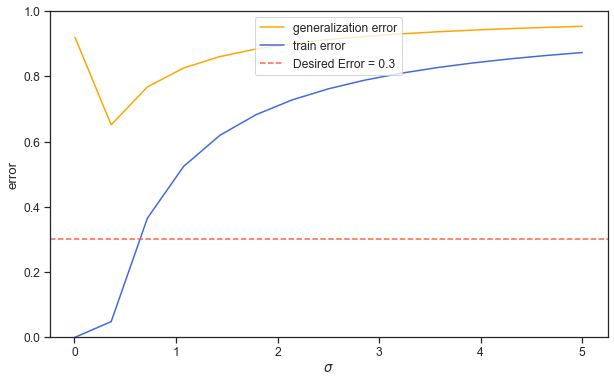

In [25]:
sigmas = np.linspace(0.005, 5, 15)
lambdas=[0]
generalization_error = []
train_error = []
for lam in lambdas:
    train_scores = []
    val_scores = []
    for sigma in sigmas:
        for train_set, val_set in cross_val_datasets:
            y_train, X_train = get_labels_and_features(train_set)
            y_val, X_val = get_labels_and_features(val_set)

            h = kernel_lr(X_train, y_train, sigma=sigma, lam=lam)

            train_scores.append(score(h, X_train, y_train))
            val_scores.append(score(h, X_val, y_val))
            #print(f'Average model accuracy for sigma={sigma}, lambda={lam}')
            #print(f'train: {sum(train_scores)/len(train_scores)}')
            #print(f'val: {sum(val_scores)/len(val_scores)}\n')
        
        generalization_error.append(1-(sum(val_scores)/len(val_scores)))
        train_error.append(1-(sum(train_scores)/len(train_scores)))
        
    plt.figure(figsize=(10, 6))
    plt.plot(sigmas, generalization_error, label='generalization error', color='orange')
    plt.plot(sigmas, train_error, label='train error', color='royalblue')
    plt.axhline(0.3, color='tomato', linestyle='--', label=f'Desired Error = {0.3}')
    plt.ylim([0, 1]);
    plt.xlabel('$\sigma$')
    plt.ylabel('error')
    plt.legend(loc='upper center');

As there can be seen there is a huge gap between Train Error and Generalization Error.
This means we have a high variance problem, and our model is overfitting.
Therefore, we add Regularization to reduce our model complexity.
Another possibility would be to add more data, however this is problematic due to the computational time.

Lets add a Regularization parameter  𝜆 .

Progress (in %) 0.0
Progress (in %) 20.0
Progress (in %) 40.0
Progress (in %) 60.0
Progress (in %) 80.0


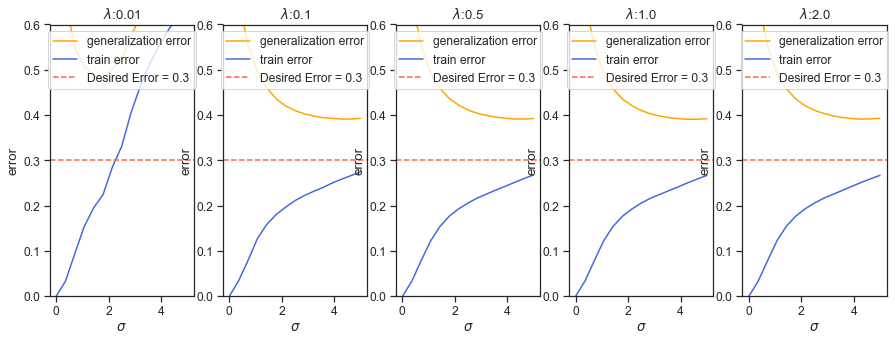

In [24]:
sigmas = np.linspace(0.005, 5, 15)
lambdas=[0.01, 0.1, 0.5, 1., 2.] #0.1, 0.01, 0.001] 

fig, axs = plt.subplots(1, len(lambdas), figsize=(15, 5))
for i, lam in enumerate(lambdas):
    generalization_error = []
    train_error = []
    train_scores = []
    val_scores = []
    plt.sca(axs[i])
    for sigma in sigmas:
        for train_set, val_set in cross_val_datasets:
            y_train, X_train = get_labels_and_features(train_set)
            y_val, X_val = get_labels_and_features(val_set)

            h = kernel_lr(X_train, y_train, sigma=sigma, lam=lam)

            train_scores.append(score(h, X_train, y_train))
            val_scores.append(score(h, X_val, y_val))
        
        # Calculate Training Error and Generalization Error      
        generalization_error.append(1-(sum(val_scores)/len(val_scores)))
        train_error.append(1-(sum(train_scores)/len(train_scores)))
    print("Progress (in %)", (i/len(lambdas))*100)
    # Plot the Errors over different lambdas
    plt.plot(sigmas, generalization_error, label='generalization error', color='orange')
    plt.plot(sigmas, train_error, label='train error', color='royalblue')
    plt.axhline(0.3, color='tomato', linestyle='--', label=f'Desired Error = {0.3}')
    plt.ylim([0, .6]);
    plt.xlabel('$\sigma$')
    plt.ylabel('error')
    plt.title(f'$\lambda$:{lam}')
    plt.legend(loc='upper center');

With the regularization term added we observe way better result with the training & generalisation errors.
We now choose the best parameters and calculate the result on the test data set.

TODO discussion: dow we need the model calculations below, since we have the error plots above?

In [16]:
sigmas=[0.5, 1., 2., 4., 8.]
lambdas=[1.]

for lam in lambdas:
    for sigma in sigmas:
        train_scores = []
        val_scores = []
        for train_set, val_set in cross_val_datasets:
            y_train, X_train = get_labels_and_features(train_set)
            y_val, X_val = get_labels_and_features(val_set)

            h = kernel_lr(X_train, y_train, sigma=sigma, lam=lam)

            train_scores.append(score(h, X_train, y_train))
            val_scores.append(score(h, X_val, y_val))
        
        print(f'Average model accuracy for sigma={sigma}, lambda={lam}')
        print(f'train: {sum(train_scores)/len(train_scores)}')
        print(f'val: {sum(val_scores)/len(val_scores)}\n')

Average model accuracy for sigma=0.5, lambda=1.0
train: 0.8614999999999999
val: 0.6885

Average model accuracy for sigma=1.0, lambda=1.0
train: 0.735
val: 0.7065

Average model accuracy for sigma=2.0, lambda=1.0
train: 0.7055
val: 0.696

Average model accuracy for sigma=4.0, lambda=1.0
train: 0.6819999999999999
val: 0.657

Average model accuracy for sigma=8.0, lambda=1.0
train: 0.6094999999999999
val: 0.5840000000000001

time: 1min (started: 2021-06-14 18:05:30 +02:00)


## Metrics

For a final evaluation of our model we calculate common metrics for comparability.

Our metrics are based around the confusion matrix.

True positive = $TP$

True negative = $TN$

False positive = $FP$

False negative = $FN$

- Accuracy: the proportion of correct predictions among the total number of predictions made.

    $Accuracy = (TP + TN) / (TP + TN + FP + FN) $

    So how accurate is our prediction of data points. Note: an overfitted model has a high accuracy.

- Precision: the proportion of the true predictions among all the positive predictions made.

    $Precision = TP / (TP + FP)$

    So how serious do we have to take a positive result. Note: when this score is low, we have lots of false alarms.

- Recall: the proportion of the true positive predictions among the total amount of relevant samples in the dataset.

    $Recall = TP / (TP + FN)$

    So how good is our model in detecting the disease. Note: when this score is low, we missed lots of cases where patients have the disease.

- F1: the harmonic mean of the precision and recall.

    $F1 = 2 * (precision * recall) / (precision + recall)$

    As neither accuracy, precision and recall can judge the model's performance on their own we use the F1 score as a final comparsion value.
    This works because the harmonic mean puts the focus on the small values.
    So when either precision **or** recall is performing badly it reflects in the F1 score.


In [17]:
# train hypothesis function on entire training set (including validation set) on best parameters
sigma = 1.
lam = 1.
y_train, X_train = get_labels_and_features(train_data)
y_test, X_test = get_labels_and_features(test_data)
h = kernel_lr(X_train, y_train, sigma=sigma, lam=lam)

time: 34.5 s (started: 2021-06-14 18:06:31 +02:00)


	---- Metrics ----
Accuracy:	 0.717085680267436
Precision:	 0.7825117464362507
Recall:		 0.6005378315609339
F1:		 0.6795532348974722

	---- Confusion Matrix ----


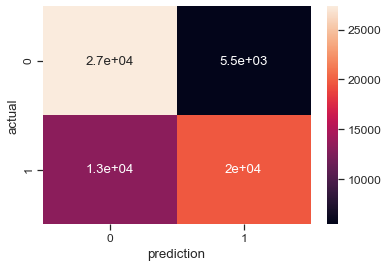

We predicted correctly that 27325 patients have no disease.
We predicted correctly that 19652 patients have a cardio disease.
But we missed 13072 patients and gave 5462 false alarms.

time: 3.53 s (started: 2021-06-14 18:07:05 +02:00)


In [18]:
# calculate metrics
X, y =  X_test, y_test

predictions = h(X)
matching_score = (predictions * y > 0).astype(int)

# true disease, false alarm, no disease, missed disease
tp, fp, tn, fn = [], [], [], []
for index, score in enumerate(predictions):
    label = y[index]
    if score > 0 and label > 0:
        tp.append(score)
    elif score > 0 and label < 0:
        fp.append(score)
    elif score <= 0 and label < 0:
        tn.append(score)
    elif score <= 0 and label > 0:
        fn.append(score)


accuracy = matching_score.sum() / matching_score.shape[0]
precision = len(tp)/ (len(tp)+ len(fp))
recall = len(tp) / (len(tp) + len(fn))
f_1 = 2 * ( (precision * recall) / (precision + recall) )


print('\t---- Metrics ----\n'
    f'Accuracy:\t {accuracy}\n'
    f'Precision:\t {precision}\n'
    f'Recall:\t\t {recall}\n'
    f'F1:\t\t {f_1}\n')


print('\t---- Confusion Matrix ----')
plot_data = [[len(tn), len(fp)],
             [len(fn), len(tp)]]
sns.heatmap(plot_data, annot=True)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.show()


print(f'We predicted correctly that {len(tn)} patients have no disease.\n'
    f'We predicted correctly that {len(tp)} patients have a cardio disease.\n'
    f'But we missed {len(fn)} patients and gave {len(fp)} false alarms.\n')

## Interpretation & Further Investigation

The result of our model are not bad, but also not perfect.
For a first prediction the model works pretty good, as in most cases the model correctly predicts the absence or presence of a disease.

It is clear that the model performance is better when it comes to false alarms (precision scores), so a doctor should give positive predictions more attention.
On the other hand, when the model predicts no disease, and the doctor thinks otherwise its save to trust the doctor, as the recall score of the model could be better.

### Additional Bias Term

As our goal was to provide a flexible tool for easier medical classification the issue with high recall values,
in other words missed cases of a disease, might not be what a doctor wants.
It might be way easier to judge a false alarm that it is to find hidden cases of the diease.


To provide more flexibility and to tackle this issue we introduce an additional bias value that can influence the proportions of false alarms to missed cases.

### Future

Our group concluded that a comparison with other algorithms, like the random forrest or k-nearest neighbors algorithm, might be useful to judge the overall performance of our Kernel Logistic Regression algorithm on this dataset

TODO: compare our results with others on kaggle -> ca. 70-75 als accuracy/ F1 score....?



